# Querying On-Disk Tables

> Objectives:
> * Compare queries of tabular data for **on-disk** containers
> * Compare sizes and times for those

In [1]:
from ipython_memwatcher import MemWatcher
mw = MemWatcher()
mw.start_watching_memory()

In [1] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 32.469 MiB


## Load movielens datasets in pandas DataFrames

Let's start loadind dataset in pandas so that we can create persistent versions more easily later on.

In [2]:
import os
dset = 'movielens-1m'
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

In [2] used 0.027 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 32.496 MiB


In [3]:
# Import CSV files via pandas
import pandas as pd
# pass in column names for each CSV
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': object, 'genres': object})

In [3] used 69.883 MiB RAM in 0.451s, peaked 2.602 MiB above current, total RAM usage 102.379 MiB


In [4]:
# Store movies and ratings in 2 separate tables in SQLite
sqlite_norm = "movielens-norm.sqlite"
if os.path.exists(sqlite_norm):
    os.unlink(sqlite_norm)
import sqlite3
conn = sqlite3.connect(sqlite_norm)
conn.text_factory = str   # Shut up problems with Unicode
ratings.to_sql("ratings", conn)
movies.to_sql("movies", conn)
conn.close()

In [4] used 121.297 MiB RAM in 2.237s, peaked 122.902 MiB above current, total RAM usage 223.676 MiB


In [5]:
# create one merged DataFrame
lens = pd.merge(movies, ratings)

In [5] used 85.137 MiB RAM in 0.124s, peaked 0.000 MiB above current, total RAM usage 308.812 MiB


In [6]:
lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
movie_id          1000209 non-null int64
title             1000209 non-null object
genres            1000209 non-null object
user_id           1000209 non-null int64
rating            1000209 non-null int64
unix_timestamp    1000209 non-null int64
dtypes: int64(4), object(2)
memory usage: 53.4+ MB
In [6] used 61.055 MiB RAM in 0.139s, peaked 0.000 MiB above current, total RAM usage 369.867 MiB


In [7]:
# Store lens denormalized in 1 table in SQLite
sqlite_denorm = "movielens-denorm.sqlite"
if os.path.exists(sqlite_denorm):
    os.unlink(sqlite_denorm)
conn_denorm = sqlite3.connect(sqlite_denorm)
conn_denorm.text_factory = str   # Shut up problems with Unicode
lens.to_sql("lens", conn_denorm)
conn_denorm.close()

In [7] used 38.430 MiB RAM in 3.136s, peaked 108.047 MiB above current, total RAM usage 408.297 MiB


In [8]:
# Get rid of unnecessary containers to save memory
del movies, ratings

In [8] used 0.023 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 408.320 MiB


In [9]:
%time result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
result

CPU times: user 36 ms, sys: 4 ms, total: 40 ms
Wall time: 34.6 ms


5121      75
5164    3842
5187    6031
Name: user_id, dtype: int64

In [9] used 0.191 MiB RAM in 0.043s, peaked 0.000 MiB above current, total RAM usage 408.512 MiB


In [10]:
# keep the run-time for reference
qtime_pandas_mem = mw.measurements.time_delta
qtime_pandas_mem

0.04275393486022949

In [10] used 0.016 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 408.527 MiB


## bcolz

`bcolz` cannot only deal with data in-memory, but also on-disk using exactly the same API.  Let's try that.

In [11]:
import bcolz
bcolz.print_versions()
bcolz.defaults.cparams['cname'] = 'lz4'
bcolz.defaults.cparams['clevel'] = 9
bcolz.defaults.cparams['shuffle'] = bcolz.BITSHUFFLE
bcolz.set_nthreads(1)

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     1.0.1.dev99
bcolz git info:    1.0.0-99-gcbe1434
NumPy version:     1.11.0
Blosc version:     1.9.1 ($Date:: 2016-05-20 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.6.1.dev0
Dask version:      0.9.0
Python version:    2.7.11 |Continuum Analytics, Inc.| (default, Dec  6 2015, 18:08:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    8
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


8

In [11] used 6.883 MiB RAM in 0.048s, peaked 0.000 MiB above current, total RAM usage 415.410 MiB


In [12]:
# Import a pandas DataFrame in a ctable on-disk
bcolz_dir = "movielens-denorm.bcolz"
if os.path.exists(bcolz_dir):
    import shutil
    shutil.rmtree(bcolz_dir)
zlens = bcolz.ctable.fromdataframe(lens, rootdir=bcolz_dir)

In [12] used 0.289 MiB RAM in 0.210s, peaked 78.211 MiB above current, total RAM usage 415.699 MiB


In [13]:
%time result = zlens["(title == b'Tom and Huck (1995)') & (rating == 5)"]['user_id']
result

CPU times: user 44 ms, sys: 12 ms, total: 56 ms
Wall time: 54.9 ms


array([  75, 3842, 6031])

In [13] used 0.023 MiB RAM in 0.058s, peaked 0.000 MiB above current, total RAM usage 415.723 MiB


In [14]:
# keep the run-time for reference
qtime_bcolz = mw.measurements.time_delta
# ...and print the result (for reference too)
result

array([  75, 3842, 6031])

In [14] used 0.027 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 415.750 MiB


In [15]:
# One can optimize the query more
%time result = [r.user_id for r in zlens.where("(title == b'Tom and Huck (1995)') & (rating == 5)", outcols=['user_id'])]

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 36.2 ms
In [15] used 0.059 MiB RAM in 0.038s, peaked 0.000 MiB above current, total RAM usage 415.809 MiB


In [16]:
# keep the run-time for reference
qtime_bcolz_opt = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [16] used 0.012 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 415.820 MiB


Let's see the space consumed on-disk:

In [17]:
!du -sh $bcolz_dir

6.3M	movielens-denorm.bcolz
In [17] used 0.215 MiB RAM in 0.118s, peaked 0.000 MiB above current, total RAM usage 416.035 MiB


and let's compare it with the internal estimated size:

In [18]:
zlens

ctable((1000209,), [('movie_id', '<i8'), ('title', 'S82'), ('genres', 'S47'), ('user_id', '<i8'), ('rating', '<i8'), ('unix_timestamp', '<i8')])
  nbytes: 153.57 MB; cbytes: 7.25 MB; ratio: 21.17
  cparams := cparams(clevel=9, shuffle=2, cname='lz4', quantize=0)
  rootdir := 'movielens-denorm.bcolz'
[(1, 'Toy Story (1995)', "Animation|Children's|Comedy", 1, 5, 978824268)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 6, 4, 978237008)
 (1, 'Toy Story (1995)', "Animation|Children's|Comedy", 8, 4, 978233496)
 ...,
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5837, 4, 1011902656)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5927, 1, 979852537)
 (3952, 'Contender, The (2000)', 'Drama|Thriller', 5998, 4, 1001781044)]

In [18] used 0.027 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 416.062 MiB


So, the internal estimated size is a bit higher than the actual size on-disk, which means that bcolz offers a conservative guess in general.

Another interesting fact is that the de-normalized version of the ctable takes less space than the normalized version in a relational database, and the query speed is still faster (than SQLite at least).

But there are other ways to store compressed tables.  Let's visit PyTables and see how it performs.

## PyTables

In [19]:
h5denorm = "movielens-denorm.h5"
if os.path.exists(h5denorm):
    os.unlink(h5denorm)
zlens.tohdf5(h5denorm, nodepath='/h5lens')

In [19] used 0.844 MiB RAM in 0.358s, peaked 0.000 MiB above current, total RAM usage 416.906 MiB


In [20]:
import tables
h5file = tables.open_file(h5denorm)
h5lens = h5file.root.h5lens

In [20] used 0.016 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 416.922 MiB


In [21]:
# Let's have a look at the HDF5 table
h5lens

/h5lens (Table(1000209,), shuffle, blosc:lz4(9)) ''
  description := {
  "movie_id": Int64Col(shape=(), dflt=0, pos=0),
  "title": StringCol(itemsize=82, shape=(), dflt='', pos=1),
  "genres": StringCol(itemsize=47, shape=(), dflt='', pos=2),
  "user_id": Int64Col(shape=(), dflt=0, pos=3),
  "rating": Int64Col(shape=(), dflt=0, pos=4),
  "unix_timestamp": Int64Col(shape=(), dflt=0, pos=5)}
  byteorder := 'little'
  chunkshape := (1628,)

In [21] used 0.012 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 416.934 MiB


In [22]:
%time result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 98.4 ms
In [22] used 0.031 MiB RAM in 0.100s, peaked 0.000 MiB above current, total RAM usage 416.965 MiB


In [23]:
# keep the run-time for reference
qtime_pytables = mw.measurements.time_delta
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [23] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 416.965 MiB


So, it seems that PyTables is more than 2x slower than bcolz (~190 ms vs 75 ms).  What about the size of the HDF5 file?

In [24]:
h5file.close()
!ls -lh $h5denorm

-rw-r--r-- 1 francesc francesc 6.5M Jun 10 13:49 movielens-denorm.h5
In [24] used 0.145 MiB RAM in 0.119s, peaked 0.000 MiB above current, total RAM usage 417.109 MiB


6.0 MB is approximately the same than the 6.0 MB that used bcolz (which is expected because both are using LZ4HC as the compressor).

## Indexing (PyTables)

PyTables can index tables for improving query speed.  Let's try that out:

In [25]:
## Copy the original PyTables table into another file
import shutil
h5idx = "movielens-indexed.h5"
if os.path.exists(h5idx):
    os.unlink(h5idx)
shutil.copyfile(h5denorm, h5idx)

In [25] used 0.000 MiB RAM in 0.017s, peaked 0.000 MiB above current, total RAM usage 417.109 MiB


In [26]:
# Open the new file in 'a'ppend mode
h5i = tables.open_file(h5idx, mode="a")

In [26] used 0.000 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 417.109 MiB


In [27]:
# Create an index for the 'title' column
h5lens = h5i.root.h5lens
h5lens.cols.title.create_csindex()

1000209

In [27] used 0.219 MiB RAM in 3.202s, peaked 118.945 MiB above current, total RAM usage 417.328 MiB


In [28]:
# ...and redo the query...
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

1 loops, best of 1: 6.1 ms per loop
In [28] used 0.035 MiB RAM in 0.014s, peaked 0.000 MiB above current, total RAM usage 417.363 MiB


In [29]:
# keep the run-time for reference
qtime_pytables_index1 = t.best
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [29] used 0.004 MiB RAM in 0.005s, peaked 0.000 MiB above current, total RAM usage 417.367 MiB


So, by indexing one column we have got a 35x of acceleration wrt PyTables (5 ms vs 180 ms).  What happens if we index the 'rating' column?

In [30]:
h5lens.cols.rating.create_csindex()

1000209

In [30] used 0.070 MiB RAM in 0.601s, peaked 0.000 MiB above current, total RAM usage 417.438 MiB


In [31]:
t = %timeit -r1 -n1 -o result = [r['user_id'] for r in h5lens.where("(title == b'Tom and Huck (1995)') & (rating == 5)")]

1 loops, best of 1: 1.23 ms per loop
In [31] used 0.020 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 417.457 MiB


In [32]:
# keep the run-time for reference
qtime_pytables_index2 = t.best
# ...and print the result (for reference too)
result

[75, 3842, 6031]

In [32] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 417.457 MiB


Ok, that's another ~3x additional acceleration, and the best time that we ever reached for this query.

In [33]:
h5i.close()

In [33] used 0.004 MiB RAM in 0.077s, peaked 0.000 MiB above current, total RAM usage 417.461 MiB


## Querying on-disk data with SQLite (relational database)

In [34]:
# Execute the query with the de-normalized SQLite database
conn = sqlite3.connect(sqlite_denorm)
c = conn.cursor()

In [34] used -0.074 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 417.387 MiB


In [35]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
%time result = [r for r in c.execute(q)]

CPU times: user 92 ms, sys: 28 ms, total: 120 ms
Wall time: 117 ms
In [35] used 0.000 MiB RAM in 0.119s, peaked 0.000 MiB above current, total RAM usage 417.387 MiB


In [36]:
# keep the run-time for reference
qtime_sqlite_denorm = mw.measurements.time_delta
# ...and print the result
result

[(75,), (3842,), (6031,)]

In [36] used 0.004 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 417.391 MiB


In [37]:
# Execute the query with the normalized SQLite database
conn = sqlite3.connect(sqlite_norm)
c = conn.cursor()

In [37] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 417.391 MiB


In [38]:
q = """
select ratings.user_id from movies 
INNER JOIN ratings ON movies.movie_id = ratings.movie_id
where movies.title == 'Tom and Huck (1995)' and ratings.rating == 5
"""
%time result = [r for r in c.execute(q)]

CPU times: user 304 ms, sys: 20 ms, total: 324 ms
Wall time: 322 ms
In [38] used 0.000 MiB RAM in 0.324s, peaked 0.000 MiB above current, total RAM usage 417.391 MiB


In [39]:
# keep the run-time for reference
qtime_sqlite_norm = mw.measurements.time_delta
# ...and print the result
result

[(75,), (3842,), (6031,)]

In [39] used 0.004 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 417.395 MiB


So in general, we see that it is much faster to query tables in denormalized form, although they take much more storage:

In [40]:
!ls -lh $sqlite_norm $sqlite_denorm

-rw-r--r-- 1 francesc francesc 78M Jun 10 13:49 movielens-denorm.sqlite
-rw-r--r-- 1 francesc francesc 37M Jun 10 13:49 movielens-norm.sqlite
In [40] used 0.004 MiB RAM in 0.113s, peaked 0.000 MiB above current, total RAM usage 417.398 MiB


In some way, storing tables in normalized form is a kind of compression, but that comes to the cost of using more time to process queries.  But indexing is the strongest point of relational databases, so let's see how it can accelerate queries:

## Indexing (SQLite)

In [41]:
sqlite_idx = "movielens-indexed.sqlite"
if os.path.exists(sqlite_idx):
    os.unlink(sqlite_idx)
shutil.copyfile(sqlite_denorm, sqlite_idx)
conn_idx = sqlite3.connect(sqlite_idx)

In [41] used 0.000 MiB RAM in 0.083s, peaked 0.000 MiB above current, total RAM usage 417.398 MiB


In [42]:
c = conn_idx.cursor()
c.execute("CREATE INDEX index_title ON lens (title)")
conn_idx.commit()

In [42] used 0.016 MiB RAM in 1.408s, peaked 30.859 MiB above current, total RAM usage 417.414 MiB


In [43]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o result = [r for r in c.execute(q)]
# keep the run-time for reference
qtime_sqlite_index1 = t.best

1 loops, best of 1: 323 µs per loop
In [43] used 0.020 MiB RAM in 0.007s, peaked 0.000 MiB above current, total RAM usage 417.434 MiB


In [44]:
# ...and print the result (for reference too)
result

[(75,), (3842,), (6031,)]

In [44] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 417.434 MiB


Wow, with quite less than 1 ms we are getting the best figure so far, and faster than the best figure with indexed PyTables.

## Exercise

What will happen if index the rating column?  We should get better speed, right?  Try it out and report the improvement that you are seeing.

### Solution

In [45]:
c.execute("CREATE INDEX index_rating ON lens (rating)")
conn_idx.commit()

In [45] used 0.000 MiB RAM in 0.609s, peaked 7.547 MiB above current, total RAM usage 417.434 MiB


In [46]:
q = "select user_id from lens where title == 'Tom and Huck (1995)' and rating == 5"
t = %timeit -r1 -n1 -o result = [r for r in c.execute(q)]

1 loops, best of 1: 123 ms per loop
In [46] used 0.004 MiB RAM in 0.128s, peaked 0.000 MiB above current, total RAM usage 417.438 MiB


Uh, we are getting far worse performance with 2 indexes. Take away lesson: indexing is a tricky thing and the best way to assess the improvement in performance is by trying it out, so do not blindly index everthing.

## Final performance comparison

In [47]:
%matplotlib inline

In [47] used 6.574 MiB RAM in 0.067s, peaked 0.000 MiB above current, total RAM usage 424.012 MiB


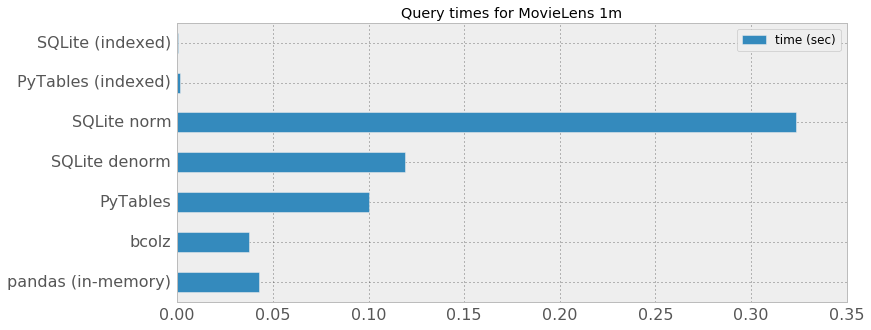

In [51] used 0.910 MiB RAM in 0.222s, peaked 0.000 MiB above current, total RAM usage 401.969 MiB


In [51]:
# Query times
labels = ["pandas (in-memory)", "bcolz", "PyTables", "SQLite denorm", "SQLite norm", "PyTables (indexed)", "SQLite (indexed)"]
df = pd.DataFrame({'time (sec)': [qtime_pandas_mem, qtime_bcolz_opt, qtime_pytables, qtime_sqlite_denorm, qtime_sqlite_norm, qtime_pytables_index2, qtime_sqlite_index1]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Query times for MovieLens 1m")

## Final size comparison

In [49]:
!du -sh movielens* | sort -n

5.8M	movielens-1m
6.3M	movielens-denorm.bcolz
6.5M	movielens-denorm.h5
11M	movielens-indexed.h5
37M	movielens-norm.sqlite
78M	movielens-denorm.sqlite
119M	movielens-indexed.sqlite
In [49] used 0.000 MiB RAM in 0.114s, peaked 0.000 MiB above current, total RAM usage 399.941 MiB


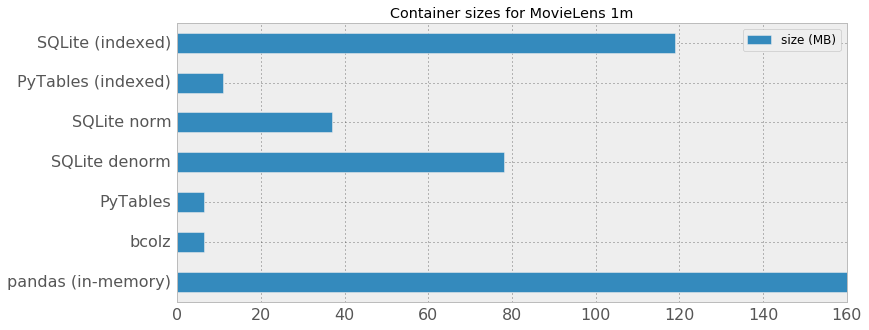

In [52] used 0.973 MiB RAM in 0.230s, peaked 0.000 MiB above current, total RAM usage 402.941 MiB


In [52]:
# Container sizes
df = pd.DataFrame({'size (MB)': [160, 6.3, 6.5, 78, 37, 11, 119]}, index=labels)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Container sizes for MovieLens 1m")

# Final Overview

Fortunately, there are many different solutions for storing large datasets both in-memory and on-disk.  Here it is a summary of the ones that we have seen in this tutorial:

* In-core
  * Python lists and dictionaries: Included in Python.  Very flexible.  Not efficient for large datasets.
  * NumPy: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * Pandas: Good for large amounts of data and with a lot of functionality.  Does not support compression.
  * bcolz: Good for large amounts of data, but reduced functionality.  Supports compression.
  
* Out-of-core
  * bcolz: Good for large datasets.  Supports compression, but not indexing.  Medium query speeds.
  * SQLite: Can be used for large datasets, but requires lots of storage.  Supports indexing.  Excellent query speeds.
  * PyTables: Good for large datasets.  Supports indexing and compression.  Good query speeds.

As you see, every solution has strengths and weaknesses, with wild variations in resource consumptions, so a wise thing to do is to know them better and try to apply the best candidate to your scenario.

As a final note, this series of tutorials is work in progress, so please contact the author in case you see some inacuracy or just want to send feedback.

**Hope you have enjoyed the ride!**